<a href="https://colab.research.google.com/github/davidlarcher/Tensorflow-LSTM-Bitcoin-forecast/blob/master/Tensorflow_time_series_LSTM_Bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
!pip install yfinance pytrends

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=8512bce46e43c4087b3d15d65a4b107156d64af5ac620e223977880ecef7d66d
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [3]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from datetime import date, datetime
from tqdm import tqdm
from pytrends.request import TrendReq

print(tf.__version__)

2.3.0


In [4]:
start_date = '2014-09-17' #first BTC avail data
end_date = str(date.today())

train_split_ratio = 0.99
window_size = 7

num_epochs = 200
batch_size = 32


In [5]:
#FinData
btc = yf.Ticker("BTC-USD").history(start=start_date, end=end_date)
eth = yf.Ticker("ETH-USD").history(start=start_date, end=end_date)
dow = yf.Ticker("^DJI").history(start=start_date, end=end_date)
gold = yf.Ticker("GC=F").history(start=start_date, end=end_date)

#TrendData
pytrend = TrendReq()
pytrend.build_payload(kw_list=['Bitcoin'])
google_trends = pytrend.interest_over_time()


In [6]:
FinData = pd.DataFrame()
FinData['BTC'] = btc['Open']
FinData['BTC_var']= abs(btc['Close']-btc['Open']).div(btc['Open'])
FinData['BTC_trend']= google_trends['Bitcoin']
FinData['ETH'] = eth['Open']
FinData['ETH_var']= abs(eth['Close']-eth['Open']).div(eth['Open'])
FinData['Gold'] = gold['Open']
FinData['Gold_var']= abs(gold['Close']-gold['Open']).div(gold['Open'])
FinData['Dow'] = dow['Open']
FinData['Dow_var']= abs(dow['Close']-dow['Open']).div(dow['Open'])
FinData['BTC_vol'] = btc['Volume']
FinData['Gold_vol'] = gold['Volume']
FinData['Dow_vol'] = dow['Volume']
FinData = FinData.interpolate() #fill missing values
FinData = FinData.fillna(method='backfill')
normalized_findata= (FinData-FinData.min())/(FinData.max()-FinData.min())
normalized_findata['Date'] = FinData.index.to_frame().subtract(datetime.strptime(start_date, '%Y-%m-%d')).div(86400000000000).astype(int)

In [7]:
normalized_findata

,BTC,BTC_var,BTC_trend,ETH,ETH_var,Gold,Gold_var,Dow,Dow_var,BTC_vol,Gold_vol,Dow_vol,Date
Date,,,,,,,,,,,,,
2014-09-17,0.014973,0.049238,0.000000,0.001718,0.028996,0.184009,0.027461,0.105691,0.027331,0.000204,0.000003,0.022070,0
2014-09-18,0.014507,0.190827,0.000000,0.001718,0.028996,0.163844,0.147315,0.108068,0.108017,0.000385,0.000002,0.020903,1
2014-09-19,0.012809,0.185784,0.000000,0.001718,0.028996,0.165961,0.046440,0.115586,0.013138,0.000432,0.000001,0.143816,2
2014-09-20,0.011284,0.096957,0.000000,0.001718,0.028996,0.164818,0.040792,0.115695,0.043409,0.000417,0.000002,0.101140,3
2014-09-21,0.011979,0.061020,0.000000,0.001718,0.028996,0.163675,0.035143,0.115804,0.073680,0.000279,0.000002,0.058463,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-04,0.520935,0.073978,0.102041,0.275037,0.012693,0.881428,0.039129,0.920125,0.132898,0.404031,0.000055,0.304256,2179
2020-09-05,0.535555,0.087730,0.102041,0.277449,0.186023,0.881428,0.039129,0.920125,0.132898,0.605666,0.000055,0.304256,2180
2020-09-06,0.517663,0.029922,0.102041,0.239719,0.073536,0.881428,0.039129,0.920125,0.132898,0.499867,0.000055,0.304256,2181


In [8]:
time = normalized_findata['Date']
normalized_findata = normalized_findata.loc[:,:'Dow_vol']

In [9]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

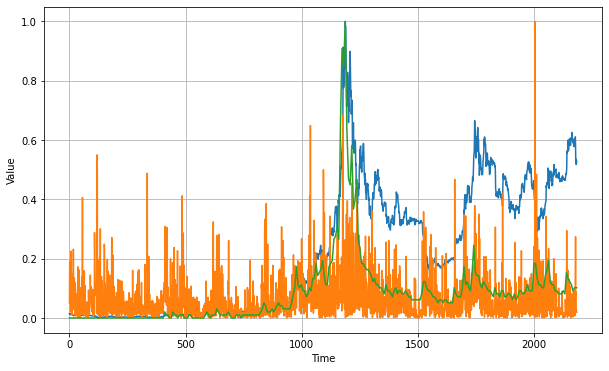

In [10]:

plt.figure(figsize=(10, 6))
plot_series(time, normalized_findata.loc[:,:'BTC_trend'])

In [11]:
n = len(normalized_findata)
train_df = normalized_findata[0:int(n*train_split_ratio)]
val_df = normalized_findata[int(n*train_split_ratio):int(n*(1-((1-train_split_ratio)/2)))]
test_df = normalized_findata[int(n*(1-((1-train_split_ratio)/2))):]

num_features = normalized_findata.shape[1]
print(num_features)
print(n)
print(len(train_df))
print(len(val_df))
print(len(test_df))

12
2183
2161
11
11


In [12]:
train_df.head()

,BTC,BTC_var,BTC_trend,ETH,ETH_var,Gold,Gold_var,Dow,Dow_var,BTC_vol,Gold_vol,Dow_vol
Date,,,,,,,,,,,,
2014-09-17,0.014973,0.049238,0.0,0.001718,0.028996,0.184009,0.027461,0.105691,0.027331,0.000204,0.000003,0.022070
2014-09-18,0.014507,0.190827,0.0,0.001718,0.028996,0.163844,0.147315,0.108068,0.108017,0.000385,0.000002,0.020903
2014-09-19,0.012809,0.185784,0.0,0.001718,0.028996,0.165961,0.046440,0.115586,0.013138,0.000432,0.000001,0.143816
2014-09-20,0.011284,0.096957,0.0,0.001718,0.028996,0.164818,0.040792,0.115695,0.043409,0.000417,0.000002,0.101140
2014-09-21,0.011979,0.061020,0.0,0.001718,0.028996,0.163675,0.035143,0.115804,0.073680,0.000279,0.000002,0.058463


In [13]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}',
        f'column name(s): {self.column_indices}',
        f'label column indice(s): {self.label_columns_indices}'
        ])

In [14]:
window = WindowGenerator(input_width=window_size, label_width=1, shift=1, label_columns=['BTC'])
window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['BTC']
column name(s): {'BTC': 0, 'BTC_var': 1, 'BTC_trend': 2, 'ETH': 3, 'ETH_var': 4, 'Gold': 5, 'Gold_var': 6, 'Dow': 7, 'Dow_var': 8, 'BTC_vol': 9, 'Gold_vol': 10, 'Dow_vol': 11}
label column indice(s): {'BTC': 0}

In [15]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [16]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:window.total_window_size]),
                           np.array(train_df[100:100+window.total_window_size]),
                           np.array(train_df[200:200+window.total_window_size])])


example_inputs, example_labels = window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 8, 12)
Inputs shape: (3, 7, 12)
labels shape: (3, 1, 1)


In [17]:
window.example = example_inputs, example_labels

In [18]:
def plot(self, model=None, plot_col='BTC', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, label_col_index], marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [day]')

WindowGenerator.plot = plot

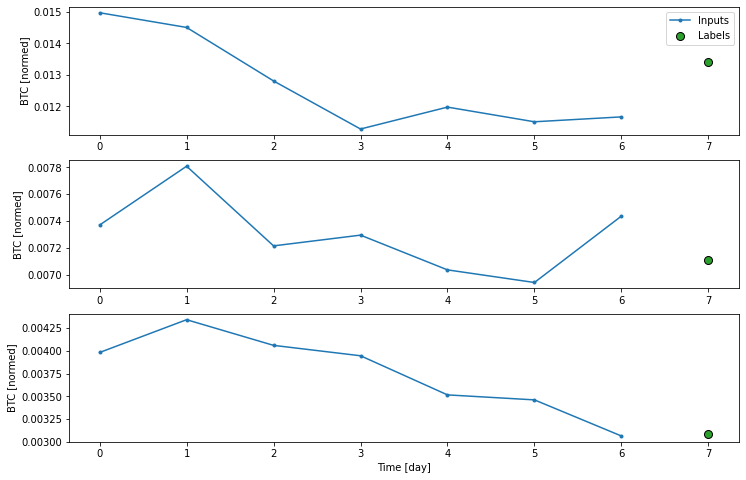

In [19]:
window.plot()

In [20]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=batch_size,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [21]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [22]:
# Each element is an (inputs, label) pair
window.train.element_spec

(TensorSpec(shape=(None, 7, 12), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [23]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = tf.keras.models.Sequential([
# Shape [batch, time, features] => [batch, time, lstm_units]
  tf.keras.layers.LSTM(window_size,input_shape=[None, num_features], return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(window_size),
  tf.keras.layers.Dense(window_size, activation="relu"),
  tf.keras.layers.Dense(1)
])

patience=10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
model.compile(loss=tf.losses.MeanAbsoluteError(),
              optimizer=tf.optimizers.RMSprop(),
              metrics=["mae"])
history = model.fit(window.train, epochs=num_epochs, validation_data=window.val, callbacks=[early_stopping])



Epoch 1/200
68/68 [==============================] - 1s 16ms/step - loss: 0.0923 - mae: 0.0923 - val_loss: 0.0517 - val_mae: 0.0517
Epoch 2/200
68/68 [==============================] - 1s 8ms/step - loss: 0.0339 - mae: 0.0339 - val_loss: 0.0560 - val_mae: 0.0560
Epoch 3/200
68/68 [==============================] - 1s 8ms/step - loss: 0.0287 - mae: 0.0287 - val_loss: 0.0427 - val_mae: 0.0427
Epoch 4/200
68/68 [==============================] - 0s 7ms/step - loss: 0.0269 - mae: 0.0269 - val_loss: 0.0616 - val_mae: 0.0616
Epoch 5/200
68/68 [==============================] - 0s 7ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0237 - val_mae: 0.0237
Epoch 6/200
68/68 [==============================] - 1s 9ms/step - loss: 0.0239 - mae: 0.0239 - val_loss: 0.0454 - val_mae: 0.0454
Epoch 7/200
68/68 [==============================] - 1s 8ms/step - loss: 0.0223 - mae: 0.0223 - val_loss: 0.0123 - val_mae: 0.0123
Epoch 8/200
68/68 [==============================] - 1s 9ms/step - loss: 0.0214 - 

In [24]:
val_performance = model.evaluate(window.val)
performance = model.evaluate(window.test, verbose=0)

1/1 [==============================] - 0s 1ms/step - loss: 0.0171 - mae: 0.0171


100%|██████████| 2176/2176 [00:12<00:00, 172.89it/s]


(2176,)


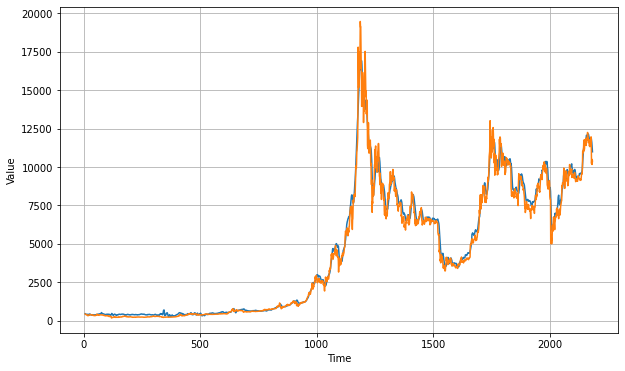

In [25]:
predictions = []
data = np.array(normalized_findata)
data = np.expand_dims(data, axis=0)
for i in tqdm(range(len(normalized_findata)-window_size)):
    current_data = data[:,i:i+window_size,:]
    pred = model(current_data)
    predictions.append(pred)
predictions = np.vstack(predictions)

predictions = np.squeeze(predictions)
resized_predictions = predictions * (FinData['BTC'].max()-FinData['BTC'].min()) + FinData['BTC'].min()

print(resized_predictions.shape)
plt.figure(figsize=(10, 6))
plot_series(time[window_size:], resized_predictions)
plot_series(time[window_size:],FinData['BTC'][window_size:])

In [26]:
last_BTC_price =  int(FinData['BTC'][-1])
predicted_price = int(resized_predictions[-1])
print(f'last Opening bitcoin price : {last_BTC_price} USD')
print(f'predicted bitcoin price : {predicted_price} USD')

last Opening bitcoin price : 10379 USD
predicted bitcoin price : 10993 USD


In [27]:
initial_wallet_USD = 10000
trading_days = 1000
trade_trigger = 0.02

In [28]:

wallet_USD = initial_wallet_USD
wallet_bitcoin = 0
data  = np.array(FinData['BTC'])
for i in range(-trading_days,0):
    current_price = data[i]
    prediction = resized_predictions[i]
    if ((prediction > (current_price * (1+trade_trigger))) and (wallet_USD >0)):
        print(f"buying BTC at {current_price}")
        wallet_bitcoin += wallet_USD/current_price
        wallet_USD = 0
    elif ((prediction < (current_price * (1+trade_trigger)))and (wallet_bitcoin >0)):
        print(f"selling BTC at {current_price}")
        wallet_USD += wallet_bitcoin * current_price
        wallet_bitcoin = 0

endvalue = wallet_USD + wallet_bitcoin * current_price
print(endvalue)
ROI = (endvalue - initial_wallet_USD)/initial_wallet_USD * 365 / trading_days * 100
print(f'ROI {ROI} %')
    

buying BTC at 15898.0
selling BTC at 16163.5
buying BTC at 12897.7
selling BTC at 14978.2
buying BTC at 13453.9
selling BTC at 13952.4
buying BTC at 11431.1
selling BTC at 12889.2
buying BTC at 10944.5
selling BTC at 11421.7
buying BTC at 11174.9
selling BTC at 11475.3
buying BTC at 10108.2
selling BTC at 8271.84
buying BTC at 9937.07
selling BTC at 10287.7
buying BTC at 9796.42
selling BTC at 10393.9
buying BTC at 9951.44
selling BTC at 8619.67
buying BTC at 8498.47
selling BTC at 7901.09
buying BTC at 9052.96
selling BTC at 8522.33
buying BTC at 8037.08
selling BTC at 7500.7
buying BTC at 7500.9
selling BTC at 7625.97
buying BTC at 7632.52
selling BTC at 6411.68
buying BTC at 6739.21
selling BTC at 6739.65
buying BTC at 7769.04
selling BTC at 6583.43
buying BTC at 6422.57
selling BTC at 6500.51
buying BTC at 6301.07
selling BTC at 6486.25
buying BTC at 6371.34
selling BTC at 6551.52
buying BTC at 6755.14
selling BTC at 6515.41
buying BTC at 6280.91
selling BTC at 6371.85
buying BTC a